# STM32功耗采集实验

本实验用于演示如何利用`Cracker-S1`采集`Nut_stm32f103c8`软件密码算法的功耗曲线。

## 准备工作

### 硬件准备
1. `Cracker-S1`功耗采集设备；
2. `Nut_stm32f103c8`测试对象；
3. POE交换机或12V适配器；
4. PC；
5. RJ45网线。

### 软件准备
1. PC安装最新版的[`CrackNuts`](https://cracknuts.cn/docs/doc/getting-started/host_sdk_installation)软件包；
2. PC安装[STM32 ST-LINK utility](https://www.st.com/en/development-tools/stsw-link004.html#get-software)固件下载程序。

### 固件烧写
1. 烧写合适的Golden固件到`Nut_stm32f103c8`

**注意：可根据需要下载不同类型的Golden固件，对比分析不同配置下的功耗差异。**

### 连接
1. 将烧写好固件的`Nut_stm32f103c8`插入`Cracker-S1`的`Nut Socket`接口；
2. 通过POE或适配器给`Cracker-S1`供电，上电后`Cracker-S1`显示IP地址;
3. 确保PC能够Ping通`Cracker-S1`的IP地址。


## 功耗采集

### 配置算法工作模式
可通过更改算法类型`alg_type`、接口类型`intf_type`和数据生成方式`data_gen`决定采集功耗曲线模式。

In [97]:
# 配置STM32运行密码算法类型、通信接口类型和数据生成类型
from enum import Enum

class AlgType(Enum):  # Algrithom type
    AES_ENC = 1
    AES_DEC = 2
    DES_ENC = 3
    DES_DEC = 4

class IntfType(Enum):  # interface type
    UART = 1
    SPI = 2
    I2C = 3
    # CAN = 4 # not support

class DataGenType(Enum):  # data type
    FIX = 1
    RANDOM = 2

# Algorithm
alg_type = AlgType.AES_ENC

# interface
intf_type = IntfType.UART

# data
data_gen = DataGenType.RANDOM

### Nut 命令

In [98]:
# AES Command
cmd_set_aes_enc_key = "01 00 00 00 00 00 00 10"
cmd_set_aes_dec_key = "01 01 00 00 00 00 00 10"
cmd_aes_enc = "01 02 00 00 00 00 00 10"
cmd_aes_dec = "01 03 00 00 00 00 00 10"
aes_key = "11 22 33 44 55 66 77 88 99 00 aa bb cc dd ee ff"
aes_data_len = 16

# DES Command
cmd_set_des_enc_key = "02 00 00 00 00 00 00 08"
cmd_set_des_dec_key = "02 01 00 00 00 00 00 08"
cmd_des_enc = "02 02 00 00 00 00 00 08"
cmd_des_dec = "02 03 00 00 00 00 00 08"
des_key = "12 34 56 78 90 ab cd ef"
des_data_len = 8

### 连接设备
下面的代码引入依赖包，并连接设备，需确保PC与Cracker-S1处于同一局域网内。

In [99]:
# 导入依赖包
import cracknuts as cn  # 导入cracknuts包
from cracknuts.cracker import serial  # 串行协议参数
from cracknuts.cracker.cracker_s1 import CrackerS1  # 导入Cracker-S1包

# 连接Cracker-S1
s1 = CrackerS1(address='192.168.0.90')  # 具体IP地址请根据Cracker-S1显示屏实际情况更改
s1.connect()  # 连接Cracker-S1

### 采集流程功能函数
代码中`init()`函数在采集流程开始时会执行1次，`do()`函数在采集流程中会执行多次。

In [100]:
import random  # for random data
import time  # for time.sleep

data_len = aes_data_len if alg_type in [AlgType.AES_ENC, AlgType.AES_DEC] else des_data_len  # data length

# init() function run only once during the acquisition process.
def init(c):
    if intf_type is IntfType.UART:  # uart interface
        # enable uart interface
        status, ret = s1.uart_enable()
        assert (status == 0) & (ret is None), "uart enable failed"
        # config uart interface
        status, ret = s1.uart_config(baudrate=serial.Baudrate.BAUDRATE_115200, 
                                     parity=serial.Parity.PARITY_NONE,
                                     stopbits=serial.Stopbits.STOPBITS_ONE, 
                                     bytesize=serial.Bytesize.EIGHTBITS)
        assert (status == 0) & (ret is None), "uart config failed"
    elif intf_type is IntfType.SPI:  # spi interface
        # enable spi interface
        s1.spi_enable()
        assert (status == 0) & (ret is None), "spi enable failed"
        # config spi interface
        s1.spi_config(speed=serial.Baudrate.BAUDRATE_115200, 
                      cpol=serial.SpiCpol.SPI_CPOL_LOW, 
                      cpha=serial.SpiCpha.SPI_CPHA_LOW)
        assert (status == 0) & (ret is None), "spi config failed"

    # combine set key command
    if alg_type is AlgType.AES_ENC:
        cmd = cmd_set_aes_enc_key + aes_key
    elif alg_type is AlgType.AES_DEC:
        cmd = cmd_set_aes_dec_key + aes_key
    elif alg_type is AlgType.DES_ENC:
        cmd = cmd_set_des_enc_key + des_key
    else:
        cmd = cmd_set_des_dec_key + des_key

    # send set key command 
    if intf_type is IntfType.UART:  # uart interface
        status, ret = s1.uart_transmit_receive(cmd, timeout=1000, rx_count=6, is_trigger=False)
        assert (status == 0) & (ret == b'\x00\x00\x00\x00\x00\x00'), "Set key failed"
    elif intf_type is IntfType.SPI:  # spi interface
        status, ret = s1.spi_transmit(tx_data=cmd_set_aes_enc_key, is_trigger=False)
        status, ret = s1.spi_transmit(tx_data=aes_key, is_trigger=False)
        # time.sleep(0.5)
        status, ret = s1.spi_receive(rx_count=6)

# do t() function run multiple times during the acquisition process.
def do(c):
    # command selection
    if alg_type is AlgType.AES_ENC:
        cmd = cmd_aes_enc        
    elif alg_type is AlgType.AES_DEC:
        cmd = cmd_aes_dec
    elif alg_type is AlgType.DES_ENC:
        cmd = cmd_des_enc        
    else:
        cmd = cmd_des_dec

    # combine command and data    
    if data_gen == DataGenType.FIX: # fix data
        data = bytes(data_len)
    else:  # random data        
        data = random.randbytes(data_len)   
    command = bytes.fromhex(cmd) + data  # combine command and data

    # send command and data
    if intf_type is IntfType.UART:
        status, ret = s1.uart_transmit_receive(command, rx_count= 6 + data_len, is_trigger=True)
        assert (status == 0) & (len(ret) == 6 + data_len), "Uart transmition failed"
    elif intf_type is IntfType.SPI:
        status, ret = s1.spi_transmit(tx_data=cmd, is_trigger=False)  # no trigger
        assert (status == 0) & (ret is None), "SPI command header transmit failed"
        status, ret = s1.spi_transmit(tx_data=data, is_trigger=True)  # triggered transmit
        assert (status == 0) & (ret is None), "SPI data transmit failed"
        time.sleep(0.2)  # wait for Nut finish computation
        status, ret = s1.spi_receive(rx_count=6 + data_len, is_trigger=False)
        assert (status == 0) & (len(ret) == 6 + data_len), "SPI data receive failed"
    
    return data + ret[-data_len:]

# init(None) # uncomment for init() debug
# do(None) # uncomment for do() debug

saveDataLength = 2 * data_len

## 图形界面方式采集

todo:cncfg

In [101]:
acq = cn.new_acquisition(s1, do=do, init= init, data_length=saveDataLength)
cn.panel(acq)

CracknutsPanelWidget(acq_run_progress={'finished': 0, 'total': 1}, connect_status=True, cracker_id='HsroJ3tJ',…

## 命令行方式采集

设置波形采集功能参数

In [102]:
status, ret = s1.osc_sample_clock('48M')
assert (status == 0) & (ret is None), "Error setting sample clock"
status, ret = s1.osc_sample_clock_phase(0)
assert (status == 0) & (ret is None), "Error setting sample clock phase"

status, ret = s1.osc_analog_enable('B')
assert (status == 0) & (ret is None), "Error enabling analog channel B"
status, ret = s1.osc_analog_gain('B', 40)
assert (status == 0) & (ret is None), "Error setting analog channel B gain"

status, ret = s1.osc_sample_length(1024 * 15)
assert (status == 0) & (ret is None), "Error setting sample length"
status, ret = s1.osc_sample_delay(0)
assert (status == 0) & (ret is None), "Error setting sample delay"

status, ret = s1.osc_trigger_mode('EDGE')
assert (status == 0) & (ret is None), "Error setting trigger mode"
status, ret = s1.osc_trigger_source('Nut')
assert (status == 0) & (ret is None), "Error setting trigger source"
status, ret = s1.osc_trigger_edge('up')
assert (status == 0) & (ret is None), "Error setting trigger edge"
status, ret = s1.osc_trigger_level(0) # Not useful for Nut trigger source
assert (status == 0) & (ret is None), "Error setting trigger level"

通信接口使能

In [105]:
status, ret = s1.uart_enable()
assert status == 0
status, ret = s1.uart_config(baudrate=serial.Baudrate.BAUDRATE_115200, 
                             parity=serial.Parity.PARITY_NONE,
                             stopbits=serial.Stopbits.STOPBITS_ONE, 
                             bytesize=serial.Bytesize.EIGHTBITS)
assert status == 0
status, ret = s1.uart_receive_fifo_remained()
assert status == 0
status, ret = s1.nut_voltage_enable()
assert (status == 0) & (ret is None), "nut voltage enable failed"

设置密钥

In [106]:
status, ret = s1.uart_transmit_receive(cmd_set_aes_enc_key + aes_key, timeout=1000, rx_count=6)
assert status == 0, "Set AES encryption key failed"
assert ret == b'\x00\x00\x00\x00\x00\x00', "Set AES encryption key failed"
print(ret)

b'\x00\x00\x00\x00\x00\x00'


In [107]:
status, ret = s1.osc_single()
assert (status == 0) & (ret is None), "Single mode failed!"

status, ret = s1.uart_transmit_receive(cmd_aes_enc + aes_key, timeout=1000, rx_count=6+ aes_data_len, is_trigger=True)
assert (status == 0) & (len(ret) == 6+ aes_data_len), "AES Encription command transfer failed!"


In [108]:
status, ret = s1.osc_is_triggered()
assert (status == 0) & (ret is True), f"Trigger error: status={status}, ret={ret}"

In [117]:
status, ret = s1.osc_get_analog_wave(1, 0, 1024*15)

In [118]:
pt = cn.panel_trace()
pt

TracePanelWidget()

todo： 显示单条曲线

In [121]:
pt.set_numpy_data(ret)

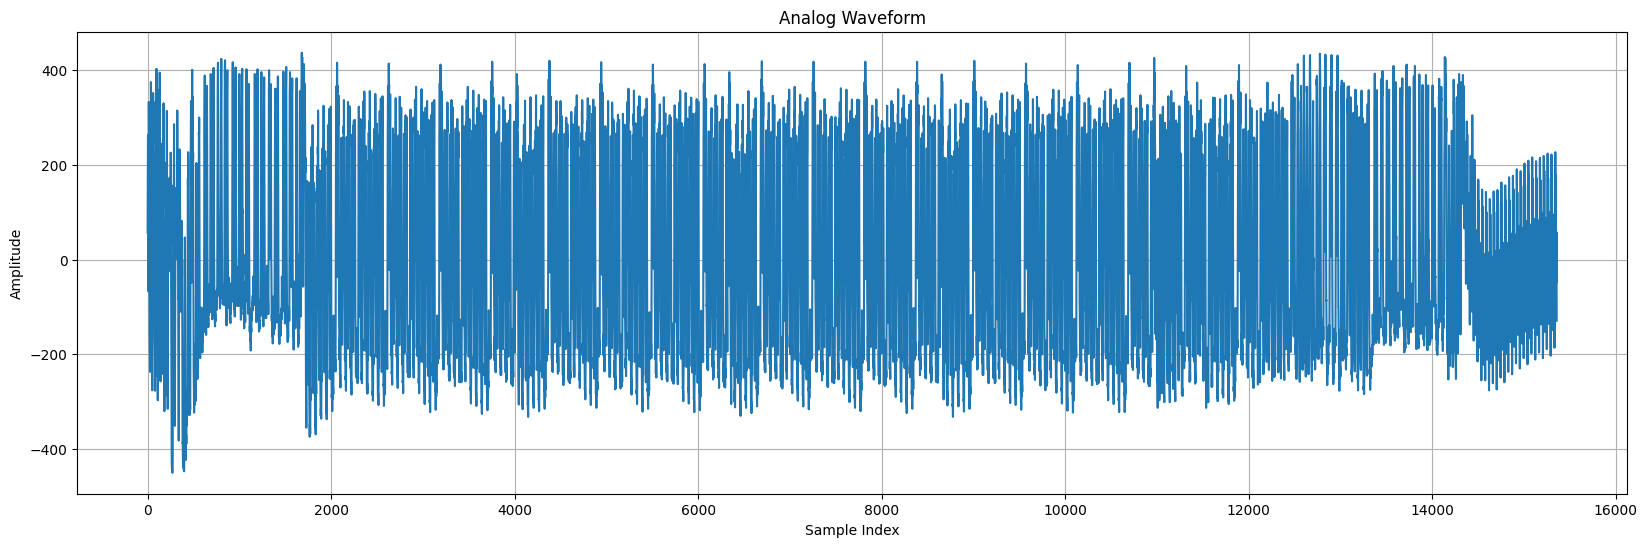

In [120]:
import matplotlib.pyplot as plt

waveform_data = ret

plt.figure(figsize=(20, 6))
plt.plot(waveform_data)
plt.title('Analog Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

todo， 循环采集，保存，查看波形